### SV calling from pairwise cigar strings - all pairs, all chroms

This notebook generates plots for SVs derived from centrolign pairwise cigar strings. 

In [1]:
# Import statements
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
## Read in input data 

# csv formatted as clade, path_to_SV_beds 
input_csv="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/12012025_clade_chr_sv_beds.csv"

# prefix for output plots
plot_prefix="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr8/test/plots/"

# pairwise distance file 
pairwise_dist="/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"

In [3]:
### This function reads in the SV bed files into a pandas DF for a given clade. 

def read_sv_bed_files(clade, chr, bed_folder):
    """
    Read all .bed files in a folder and add a 'clade' column to the data frame
    Each bed file has columns:
        sample1, start, end, sample2, start, end, type, diff
    """
    all_beds = []
    bed_files = [f for f in os.listdir(bed_folder) if f.endswith(".bed")]
    print(f"Found {len(bed_files)} SV bed files for clade '{clade}'")

    # Ensure folder exists
    if not os.path.isdir(bed_folder):
        raise FileNotFoundError("Folder not found for clade '{}': {}".format(clade, bed_folder))

    for filename in os.listdir(bed_folder):
        if filename.endswith(".bed"):
            bed_path = os.path.join(bed_folder, filename)
            try:
                df = pd.read_csv(
                    bed_path,
                    sep="\t",
                    header=None,
                    names=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff"]
                )
                df["clade"] = clade
                df["chr"] = chr
                df["source_file"] = filename  # optional, helps track origin
                df["length"] = np.where(
                    df["type"] == "I",
                    df["end2"] - df["start2"],  # insertion → use sample2 coords
                    df["end1"] - df["start1"]  # otherwise (deletion) → sample1 coords
                )
                all_beds.append(df)
            except Exception as e:
                print("Warning: Could not read {}: {}".format(bed_path, e))

    if all_beds:
        return pd.concat(all_beds, ignore_index=True)
    else:
        print("Warning: No .bed files found in {} for clade '{}'".format(bed_folder, clade))
        return pd.DataFrame(columns=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff", "clade", "source_file","chr"])

In [4]:
### For all clades in provided input csv, read SVs into dataframe and merge 

clade_info = pd.read_csv(input_csv)
if not {"clade", "chr","path_to_SV_beds"}.issubset(clade_info.columns):
    raise ValueError("Input CSV must contain columns: 'clade' and 'chr' and 'path_to_SV_beds'")

#clade_info_subset= clade_info.head(6)

all_data = []

for _, row in clade_info.iterrows():
    clade = str(row["clade"])
    chr = str(row["chr"])
    bed_folder = str(row["path_to_SV_beds"])
    df = read_sv_bed_files(clade, chr, bed_folder)
    if not df.empty:
        all_data.append(df)

if all_data:
    merged_df = pd.concat(all_data, ignore_index=True)

    #print("=== Head of merged DataFrame ===")
    #(merged_df.head(), "\n")

    # Print count of rows per clade
    print("=== Record count per clade ===")
    print(merged_df["clade"].value_counts())

Found 10440 SV bed files for clade 'chr5_subgroup0'
Found 18528 SV bed files for clade 'chr5_subgroup1'
Found 17205 SV bed files for clade 'chr12_subgroup0'
Found 17391 SV bed files for clade 'chr12_subgroup1'
Found 18336 SV bed files for clade 'chr8_subgroup0'
Found 12403 SV bed files for clade 'chr8_subgroup1'
Found 9591 SV bed files for clade 'chr17'
Found 6786 SV bed files for clade 'chr18'
Found 18721 SV bed files for clade 'chr6'
Found 27077 SV bed files for clade 'chr2'
Found 7750 SV bed files for clade 'chr4'
Found 9453 SV bed files for clade 'chr3'
Found 14422 SV bed files for clade 'chrX'
Found 19110 SV bed files for clade 'chr7_subgroup0'
Found 5050 SV bed files for clade 'chr7_subgroup1'
Found 16110 SV bed files for clade 'chr22_subgroup0'
Found 17391 SV bed files for clade 'chr22_subgroup1'
Found 11026 SV bed files for clade 'chr20_subgroupB'
Found 16110 SV bed files for clade 'chr20_subgroupD'
Found 8121 SV bed files for clade 'chr1_subgroupA'
Found 12246 SV bed files for

In [9]:
# Directory containing CSV files
pairwise_dist_dir = pairwise_dist  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None, names=['sample1', 'sample2', 'pairwise_dist'])
    df["chr"] = chr_val

    all_dfs.append(df)

# Combine into one dataframe
dist_df = pd.concat(all_dfs, ignore_index=True)

In [8]:
## Combine pairwise dists and SVs into single dataframe 
# Sort sample pairs so ordering doesn't matter
df_dist_sorted = dist_df.copy()
df_dist_sorted[['sample1', 'sample2']] = np.sort(df_dist_sorted[['sample1', 'sample2']], axis=1)

df_sv_sorted = merged_df.copy()
df_sv_sorted[['sample1', 'sample2']] = np.sort(df_sv_sorted[['sample1', 'sample2']], axis=1)

# Merge on sample1, sample2, AND chr
df_sv_sorted = df_sv_sorted.merge(df_dist_sorted, on=['sample1', 'sample2', 'chr'], how='left')

df_sv_sorted.head()

# Save dataframe to phoenix to avoid re-creating it again
df_sv_sorted.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/all_chroms_SV_df.parquet")

In [3]:
## read in saved dataframe 
df_sv_sorted = pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/all_chroms_SV_df.parquet")

In [4]:
print(df_sv_sorted.head())

   sample1  start1   end1    sample2  start2  end2 type  diff           clade  \
0  HG002.1     963  11456  HG03742.2     963   964    D  -1.0  chr5_subgroup0   
1  HG002.1   13009  16731  HG03742.2    2516  2517    D  -1.0  chr5_subgroup0   
2  HG002.1   16882  16883  HG03742.2    2667  3006    I  -1.0  chr5_subgroup0   
3  HG002.1   16924  17264  HG03742.2    3048  3049    D  -1.0  chr5_subgroup0   
4  HG002.1   20842  23243  HG03742.2    6626  6627    D   0.0  chr5_subgroup0   

    chr            source_file  length  pairwise_dist  
0  chr5  HG002.1_HG03742.2.bed   10493       0.917844  
1  chr5  HG002.1_HG03742.2.bed    3722       0.917844  
2  chr5  HG002.1_HG03742.2.bed     339       0.917844  
3  chr5  HG002.1_HG03742.2.bed     340       0.917844  
4  chr5  HG002.1_HG03742.2.bed    2401       0.917844  


In [5]:
# Create a sample_pair identifier
df_sv_sorted["sample_pair"] = df_sv_sorted["sample1"] + "_" + df_sv_sorted["sample2"]

/data/tmp/ipykernel_2377993/3019868906.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/3019868906.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/3019868906.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


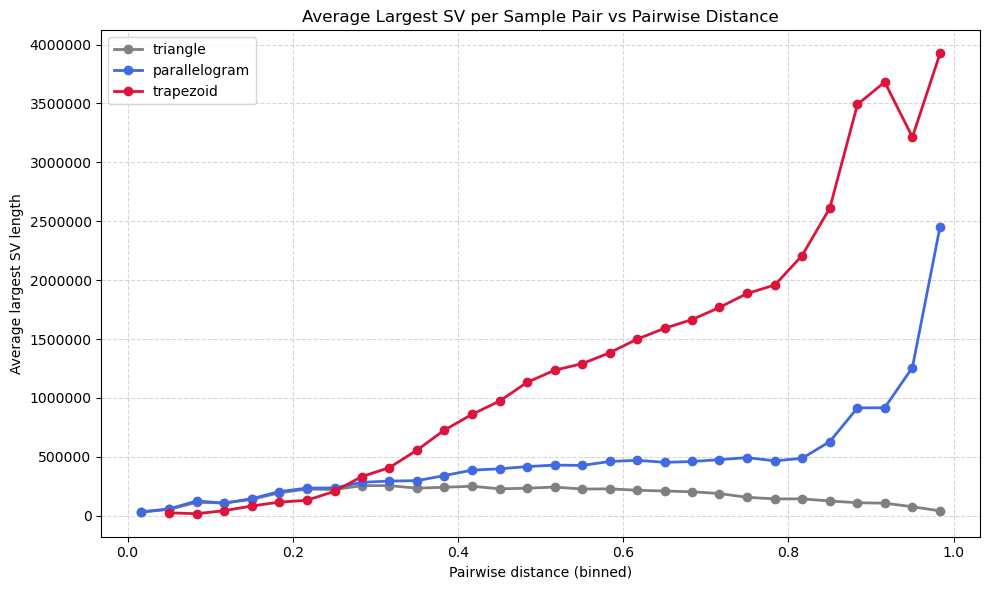

In [11]:
### All chromosomes combined 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Ensure sample_pair is defined
df_sv_sorted["sample_pair"] = df_sv_sorted["sample1"] + "_" + df_sv_sorted["sample2"]


conditions = {
    "triangle":  (df_sv_sorted["diff"] == -1),
    "parallelogram": (df_sv_sorted["diff"] < 0.1),
    "trapezoid": (df_sv_sorted["diff"] > 0.1)
}

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}


# -------------------------------------------------------
# 1. Define bins over pairwise distance
# -------------------------------------------------------
n_bins = 30
df_sv_sorted['pairwise_dist'] = df_sv_sorted['pairwise_dist'].astype(float)
bins = pd.cut(df_sv_sorted["pairwise_dist"], bins=n_bins)


# -------------------------------------------------------
# 2. Function: largest SV per sample pair
# -------------------------------------------------------
def get_largest_sv(subset):
    largest = (
        subset.sort_values("length", ascending=False)
              .groupby("sample_pair", as_index=False)
              .first()   # row with maximum 'length'
    )
    return largest


# -------------------------------------------------------
# 3. Compute mean largest-SV per bin per condition
# -------------------------------------------------------
plot_df = []

for label, mask in conditions.items():
    subset = df_sv_sorted[mask].copy()

    # collapse to largest SV per sample_pair
    largest = get_largest_sv(subset)

    # bin distances for these pairs
    largest["dist_bin"] = pd.cut(largest["pairwise_dist"], bins=bins.cat.categories)

    # compute mean length per bin
    stats = (
        largest.groupby("dist_bin")["length"]
               .mean()
               .reset_index(name="mean_length")
    )
    stats["condition"] = label
    plot_df.append(stats)

plot_df = pd.concat(plot_df, ignore_index=True)


# -------------------------------------------------------
# 4. Plot
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for label in conditions.keys():
    df_c = plot_df[plot_df["condition"] == label].copy()

    # x-axis = midpoint of each distance bin
    df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

    ax.plot(
        df_c["midpoint"],
        df_c["mean_length"],
        marker="o",
        color=colors[label],
        linewidth=2,
        label=label
    )

ax.set_xlabel("Pairwise distance (binned)")
ax.set_ylabel("Average largest SV length")
ax.set_title("Average Largest SV per Sample Pair vs Pairwise Distance")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

yfmt = ScalarFormatter(useOffset=False)
yfmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.tight_layout()
plt.show()

/data/tmp/ipykernel_2377993/3947507109.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/3947507109.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/3947507109.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/3947507109.py:45: FutureWarning: The def

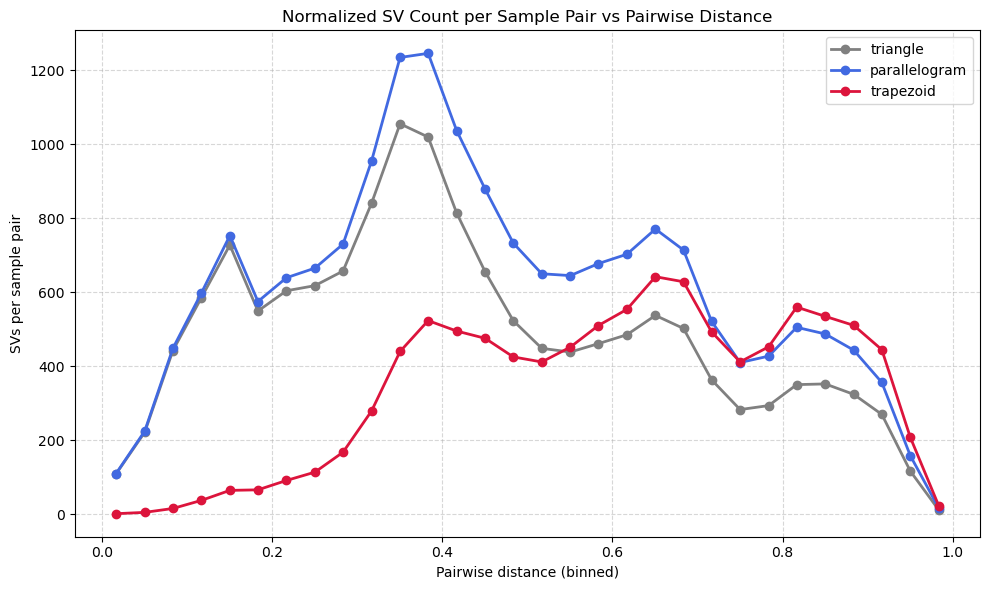

In [12]:
# All chromosomes combined 
from matplotlib.ticker import ScalarFormatter

conditions = {
    "triangle":  (df_sv_sorted["diff"] == -1),
    "parallelogram": (df_sv_sorted["diff"] < 0.1),
    "trapezoid": (df_sv_sorted["diff"] > 0.1)
}

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}

# -------------------------------------------------------
# 1. Define global distance bins
# -------------------------------------------------------
n_bins = 30
df_sv_sorted["dist_bin"] = pd.cut(df_sv_sorted["pairwise_dist"], bins=n_bins)

# -------------------------------------------------------
# 2. Count how many sample pairs occur in each bin
# -------------------------------------------------------
# One row per sample-pair for correct weighting
pairs = df_sv_sorted.groupby("sample_pair", as_index=False)["pairwise_dist"].first()
pairs["dist_bin"] = pd.cut(pairs["pairwise_dist"], bins=df_sv_sorted["dist_bin"].cat.categories)

sample_pair_counts = (
    pairs.groupby("dist_bin")
         .size()
         .reset_index(name="num_pairs_in_bin")
)

# -------------------------------------------------------
# 3. Count SVs per bin per condition
# -------------------------------------------------------
plot_df = []

for label, mask in conditions.items():

    subset = df_sv_sorted[mask]

    sv_counts = (
        subset.groupby("dist_bin")
              .size()
              .reset_index(name="sv_count")
    )

    # merge in the number of sample pairs in that bin
    merged = sv_counts.merge(sample_pair_counts, on="dist_bin", how="left")

    # Normalize:
    merged["svs_per_pair"] = merged["sv_count"] / merged["num_pairs_in_bin"]

    merged["condition"] = label
    plot_df.append(merged)

plot_df = pd.concat(plot_df, ignore_index=True)

# -------------------------------------------------------
# 4. Plot normalized SV counts
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for label in conditions.keys():
    df_c = plot_df[plot_df["condition"] == label].copy()

    # Convert bins to midpoints for plotting
    df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

    ax.plot(
        df_c["midpoint"],
        df_c["svs_per_pair"],
        marker="o",
        color=colors[label],
        linewidth=2,
        label=label
    )

ax.set_xlabel("Pairwise distance (binned)")
ax.set_ylabel("SVs per sample pair")
ax.set_title("Normalized SV Count per Sample Pair vs Pairwise Distance")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()


yfmt = ScalarFormatter(useOffset=False)
yfmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.tight_layout()
plt.show()

In [18]:
# ensure pairwise_dist is numeric
df_sv_sorted['pairwise_dist'] = pd.to_numeric(df_sv_sorted['pairwise_dist'], errors='coerce')

# group by chromosome
result = []

for chrom, g in df_sv_sorted.groupby('chr'):

    total_pairs = len(g)

    pairs_le_04 = (g['pairwise_dist'] <= 0.4).sum()
    pairs_le_06 = (g['pairwise_dist'] <= 0.6).sum()
    pairs_le_08 = (g['pairwise_dist'] <= 0.8).sum()

    # unique samples from both sample1 and sample2 columns
    samples = pd.unique(g[['sample1', 'sample2']].values.ravel())
    num_samples = len(samples)

    result.append({
        "chr": chrom,
        "num_samples": num_samples,
        "total_pairs": total_pairs,
        "pairs_le_0_4": pairs_le_04,
        "pairs_le_0_6": pairs_le_06,
        "pairs_le_0_8": pairs_le_08
    })

summary_df = pd.DataFrame(result).sort_values(by="chr")

summary_df.to_csv("/private/groups/patenlab/mira/chromosome_pair_counts.csv", index=False)

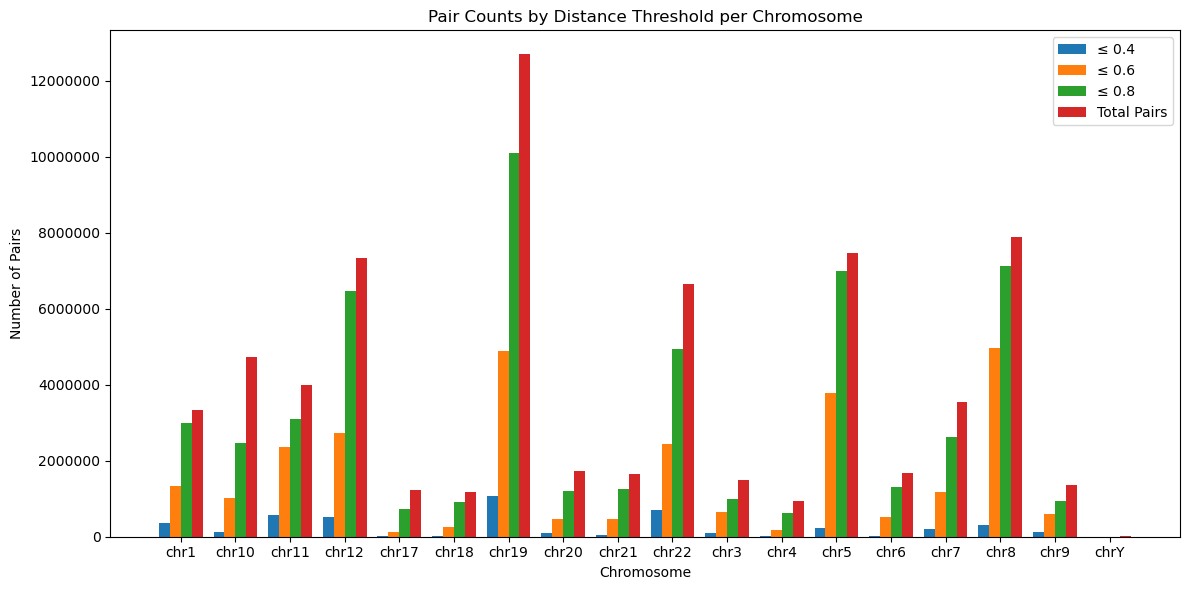

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# columns to plot
cols = ["pairs_le_0_4", "pairs_le_0_6", "pairs_le_0_8", "total_pairs"]
labels = ["≤ 0.4", "≤ 0.6", "≤ 0.8", "Total Pairs"]

# x positions for chromosomes
x = np.arange(len(summary_df['chr']))
width = 0.2  # width of each bar
fig, ax = plt.subplots(figsize=(12, 6))

# offsets for each bar
offsets = [-1.5*width, -0.5*width, 0.5*width, 1.5*width]

# plot bars
for i, col in enumerate(cols):
    ax.bar(x + offsets[i], summary_df[col], width, label=labels[i])

# labels and formatting
ax.set_xlabel("Chromosome")
ax.set_ylabel("Number of Pairs")
ax.set_title("Pair Counts by Distance Threshold per Chromosome")
ax.set_xticks(x)
ax.set_xticklabels(summary_df["chr"])
ax.legend()

yfmt = ScalarFormatter(useOffset=False)
yfmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.tight_layout()
plt.show()


In [4]:
### Read in SVs from direct pairwise 

# csv formatted as clade, path_to_SV_beds 
input_csv="/private/groups/patenlab/mira/centrolign/analysis/SVs_direct_pairwise/12022025_clade_chr_sv_beds.csv"

clade_info_direct = pd.read_csv(input_csv)
if not {"clade", "chr","path_to_SV_beds"}.issubset(clade_info_direct.columns):
    raise ValueError("Input CSV must contain columns: 'clade' and 'chr' and 'path_to_SV_beds'")

#clade_info_subset= clade_info_direct.head(6)

all_data_direct = []

for _, row in clade_info_direct.iterrows():
    clade = str(row["clade"])
    chr = str(row["chr"])
    bed_folder = str(row["path_to_SV_beds"])
    df = read_sv_bed_files(clade, chr, bed_folder)
    if not df.empty:
        all_data_direct.append(df)

if all_data_direct:
    merged_df_direct = pd.concat(all_data_direct, ignore_index=True)

    #print("=== Head of merged DataFrame ===")
    #(merged_df.head(), "\n")

    # Print count of rows per clade
    print("=== Record count per clade ===")
    print(merged_df_direct["clade"].value_counts())

Found 10440 SV bed files for clade 'chr5_subgroup0'
Found 18528 SV bed files for clade 'chr5_subgroup1'
Found 17205 SV bed files for clade 'chr12_subgroup0'
Found 17391 SV bed files for clade 'chr12_subgroup1'
Found 18336 SV bed files for clade 'chr8_subgroup0'
Found 12403 SV bed files for clade 'chr8_subgroup1'
Found 9591 SV bed files for clade 'chr17'
Found 6786 SV bed files for clade 'chr18'
Found 18721 SV bed files for clade 'chr6'
Found 75078 SV bed files for clade 'chr2'
Found 7750 SV bed files for clade 'chr4'
Found 9453 SV bed files for clade 'chr3'
Found 47278 SV bed files for clade 'chrX'
Found 19110 SV bed files for clade 'chr7_subgroup0'
Found 5050 SV bed files for clade 'chr7_subgroup1'
Found 16110 SV bed files for clade 'chr22_subgroup0'
Found 17391 SV bed files for clade 'chr22_subgroup1'
Found 53956 SV bed files for clade 'chr20_subgroupB'
Found 53956 SV bed files for clade 'chr20_subgroupD'
Found 20100 SV bed files for clade 'chr1_subgroupA'
Found 12246 SV bed files fo

In [7]:
# merge induced and direct dfs for chrom subsets 
df_sv_sorted['label'] = 'induced'
merged_df_direct['label'] = 'direct'

# Concatenate the two dataframes
df_induced_direct_combined = pd.concat([df_sv_sorted, merged_df_direct], ignore_index=True)

In [8]:
df_induced_direct_combined.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist,label
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844,induced
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844,induced
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844,induced
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844,induced
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844,induced


In [8]:
### Add new column to dataframe classifying the "shape" category of each SV 

def classify_shape(diff):
    if diff == -1:
        return "triangle"
    elif 0 <= diff <= 0.1:
        return "parallelogram"
    elif diff > 0.1:
        return "trapezoid"
    else:
        return np.nan

In [ ]:


df_induced_direct_combined["shape"] = df_induced_direct_combined["diff"].apply(classify_shape)

df_induced_direct_combined.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist,label,shape
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844,induced,triangle
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844,induced,triangle
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844,induced,triangle
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844,induced,triangle
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844,induced,parallelogram


In [11]:
# Save dataframe to phoenix to avoid re-creating it again
df_induced_direct_combined.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/df_induced_direct_combined.parquet")

In [4]:
## Read in full dataframe with induced and direct SVs 
df_induced_direct_combined = pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/df_induced_direct_combined.parquet")

KeyboardInterrupt: 

In [ ]:
# realized I neglected to add the pairwise distances to the direct SVs df before merging, so those vals are all NA.

# subset out direct SVs from combined df 
df_direct = df_induced_direct_combined[df_induced_direct_combined["label"] == "direct"]

# Sort sample pairs in pairwise dist dataframe so ordering doesn't matter
df_dist_sorted = dist_df.copy()
df_dist_sorted[['sample1', 'sample2']] = np.sort(df_dist_sorted[['sample1', 'sample2']], axis=1)

# sort sample pairs in direct SV dataframe 
df_direct_sorted = df_direct.copy()
df_direct_sorted[['sample1', 'sample2']] = np.sort(df_direct_sorted[['sample1', 'sample2']], axis=1)

# Merge pairwise dists into the direct dataframe, on sample1, sample2, AND chr
df_direct_sorted = df_direct_sorted.merge(df_dist_sorted, on=['sample1', 'sample2', 'chr'], how='left')

df_direct_sorted.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist_x,label,shape,distance_bin,pairwise_dist_y
0,HG002.1,2716,13205,HG03742.2,2716,2717,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10489,NaN,direct,triangle,NaN,0.917844
1,HG002.1,13914,17641,HG03742.2,3425,3426,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3727,NaN,direct,triangle,NaN,0.917844
2,HG002.1,24681,25355,HG03742.2,10465,10466,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,674,NaN,direct,triangle,NaN,0.917844
3,HG002.1,26228,26229,HG03742.2,11338,14731,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3393,NaN,direct,triangle,NaN,0.917844
4,HG002.1,27851,27852,HG03742.2,16353,22797,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,6444,NaN,direct,triangle,NaN,0.917844


In [ ]:
# rename columns 
df_direct_sorted = df_direct_sorted.drop("pairwise_dist_x", axis=1)
df_direct_sorted = df_direct_sorted.rename(columns={"pairwise_dist_y": "pairwise_dist"})
df_direct_sorted.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,label,shape,distance_bin,pairwise_dist
0,HG002.1,2716,13205,HG03742.2,2716,2717,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10489,direct,triangle,NaN,0.917844
1,HG002.1,13914,17641,HG03742.2,3425,3426,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3727,direct,triangle,NaN,0.917844
2,HG002.1,24681,25355,HG03742.2,10465,10466,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,674,direct,triangle,NaN,0.917844
3,HG002.1,26228,26229,HG03742.2,11338,14731,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3393,direct,triangle,NaN,0.917844
4,HG002.1,27851,27852,HG03742.2,16353,22797,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,6444,direct,triangle,NaN,0.917844


In [30]:
df_induced_direct_combined = pd.concat([df_induced, df_direct_sorted])

df_induced_direct_combined.head()


,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist,label,shape,distance_bin
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844,induced,triangle,0.8–1.0
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844,induced,triangle,0.8–1.0
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844,induced,triangle,0.8–1.0
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844,induced,triangle,0.8–1.0
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844,induced,parallelogram,0.8–1.0


In [31]:
df_induced_direct_combined.tail()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist,label,shape,distance_bin
101240123,HG02056.1,1932360,1936777,NA20805.1,1974865,1974866,D,-1.000000,chr16_subgroup_C,chr16,HG02056.1_NA20805.1.bed,4417,0.854467,direct,triangle,NaN
101240124,HG02056.1,1937355,1966178,NA20805.1,1975443,1975444,D,0.918121,chr16_subgroup_C,chr16,HG02056.1_NA20805.1.bed,28823,0.854467,direct,trapezoid,NaN
101240125,HG02056.1,1966178,1966179,NA20805.1,1975443,1977803,I,0.918121,chr16_subgroup_C,chr16,HG02056.1_NA20805.1.bed,2360,0.854467,direct,trapezoid,NaN
101240126,HG02056.1,1973029,1974729,NA20805.1,1984653,1984654,D,-1.000000,chr16_subgroup_C,chr16,HG02056.1_NA20805.1.bed,1700,0.854467,direct,triangle,NaN
101240127,HG02056.1,1974892,1985087,NA20805.1,1984816,1984817,D,-1.000000,chr16_subgroup_C,chr16,HG02056.1_NA20805.1.bed,10195,0.854467,direct,triangle,NaN


In [35]:
# Save dataframe to phoenix 
df_induced_direct_combined.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/df_induced_direct_combined_v2.parquet")

In [5]:
### Read in dataframe 
df_induced_direct_combined = pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/df_induced_direct_combined_v2.parquet")

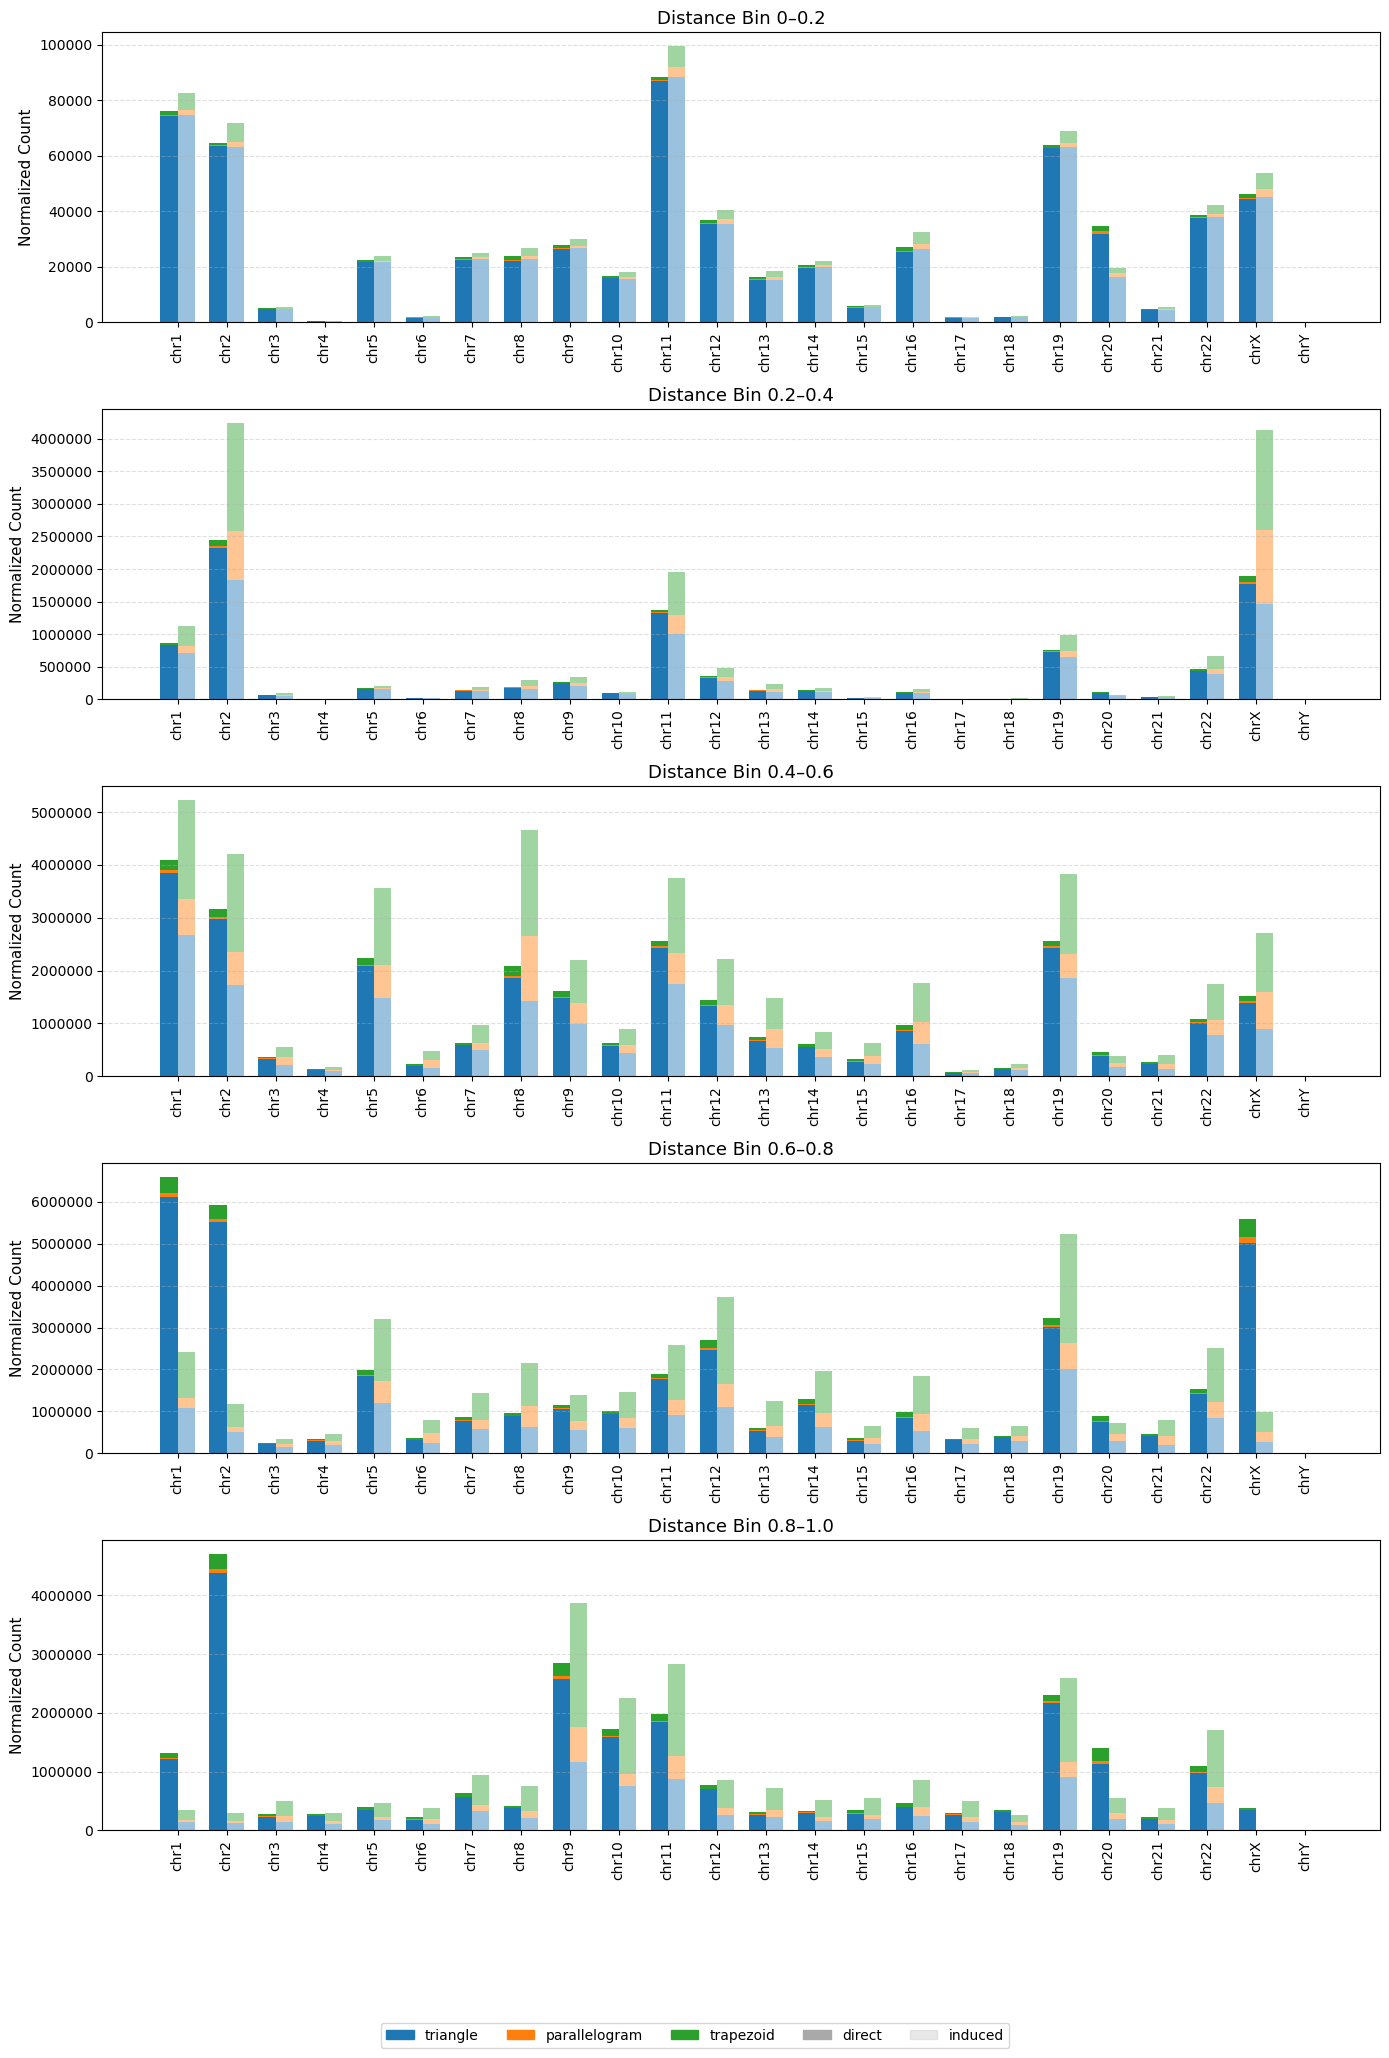

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick

shape_cols = ["triangle", "parallelogram", "trapezoid"]
shape_colors = {
    "triangle": "#1f77b4",
    "parallelogram": "#ff7f0e",
    "trapezoid": "#2ca02c"
}

# Distance bins
distance_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
distance_labels = ['0–0.2', '0.2–0.4', '0.4–0.6', '0.6–0.8', '0.8–1.0']

df_induced_direct_combined["distance_bin"] = pd.cut(
    df_induced_direct_combined["pairwise_dist"],
    bins=distance_bins,
    labels=distance_labels,
    include_lowest=True
)

bins_order = distance_labels

# Sort chromosomes naturally
def chr_sort_key(c):
    try:
        return int(c.replace("chr", ""))
    except:
        return 9999

chromosomes = sorted(df_induced_direct_combined["chr"].unique(), key=chr_sort_key)

fig, axes = plt.subplots(len(bins_order), 1, figsize=(14, 4 * len(bins_order)))
axes = np.ravel(axes)

# Offset so induced appears beside direct
bar_width = 0.35
offsets = {"direct": -bar_width/2, "induced": bar_width/2}
alpha_vals = {"direct": 1.0, "induced": 0.45}   # induced lighter

# Compute number of sample pairs per chromosome
num_pairs_per_chrom = (
    df_induced_direct_combined
    .groupby("chr")
    .size()
    .reindex(chromosomes, fill_value=0)
)

# Compute average array length per chromosome
avg_array_length_per_chr = (
    df_induced_direct_combined
    .groupby("chr")["length"]          # <-- change to your column name if needed
    .mean()
    .reindex(chromosomes, fill_value=1)      # avoid division by zero
)

for i, bin_label in enumerate(bins_order):
    ax = axes[i]

    df_bin = df_induced_direct_combined[df_induced_direct_combined["distance_bin"] == bin_label]

    # Prepare container for bars
    for label in ["direct", "induced"]:
        df_sub = df_bin[df_bin["label"] == label]

        # Count shapes per chromosome
        counts = df_sub.groupby(["chr", "shape"]).size().unstack(fill_value=0)

        for s in shape_cols:
            if s not in counts.columns:
                counts[s] = 0

        counts = counts.reindex(chromosomes, fill_value=0)

        # NORMALIZATION -------------------------------------------------
        # << optional: divide by sample pairs per chromosome >>
        #counts = counts.div(num_pairs_per_chrom, axis=0)
        #
        # << optional: divide by array length >>
        #counts = counts.div(avg_array_length_per_chr, axis=0)
        # ---------------------------------------------------------------

        # X positions for bars
        x = np.arange(len(chromosomes)) + offsets[label]

        # Stacked bars
        cumulative = np.zeros(len(chromosomes))
        for shape in shape_cols:
            ax.bar(
                x,
                counts[shape],
                bottom=cumulative,
                width=bar_width,
                color=shape_colors[shape],
                alpha=alpha_vals[label],
                label=f"{shape} ({label})" if i == 0 else None
            )
            cumulative += counts[shape].values

    ax.set_title(f"Distance Bin {bin_label}", fontsize=13)
    ax.set_ylabel("Normalized Count", fontsize=11)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

    # Chromosome labels on axis middle between direct/induced pair
    ax.set_xticks(np.arange(len(chromosomes)))
    ax.set_xticklabels(chromosomes, rotation=90)

import matplotlib.patches as mpatches

# Existing shape legend patches
shape_handles = [
    mpatches.Patch(color=shape_colors[s], label=s)
    for s in shape_cols
]

# New patches for alignment types
direct_patch  = mpatches.Patch(color="darkgray",  label="direct",  alpha=1.0)
induced_patch = mpatches.Patch(color="lightgray", label="induced", alpha=0.5)

# Combine all patches
all_handles = shape_handles + [direct_patch, induced_patch]
all_labels  = [h.get_label() for h in all_handles]

# Single combined legend
fig.legend(
    all_handles,
    all_labels,
    loc="lower center",
    ncol=5,   # adjust if needed
    bbox_to_anchor=(0.5, -0.03)
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [6]:
# read in alpha sat array sizes

# Path to the folder containing TSV files
folder_path = "/private/groups/migalab/juklucas/censat_regions/active_arrays"

# List all files in the folder
all_files = os.listdir(folder_path)

# Filter files matching asat_arrays_${chr}.tsv, exclude ones with "_raw"
tsv_files = [f for f in all_files if f.startswith("asat_arrays_") and f.endswith(".tsv") and "_raw" not in f]

all_dfs = []

for tsv_file in tsv_files:
    # Extract chr from filename using string split
    # Example: "asat_arrays_chr12.tsv" -> "chr12"
    chr_label = tsv_file.replace("asat_arrays_", "").replace(".tsv", "")

    # Build full path
    file_path = os.path.join(folder_path, tsv_file)

    # Read TSV
    df = pd.read_csv(file_path, sep="\t")

    # Keep only desired columns
    df = df[["asat_start", "asat_end", "sample_id", "haplotype"]].copy()

    # Create combined haplotype.assembly_id column
    df["sample"] = df["sample_id"].astype(str) + "." + df["haplotype"].astype(str)

    # Add chr column from filename
    df["chr"] = chr_label

    all_dfs.append(df)

# Concatenate all files into a single DataFrame
asat_df = pd.concat(all_dfs, ignore_index=True)

# Optional: keep only relevant columns
asat_df = asat_df[["asat_start", "asat_end", "sample", "chr"]]

print(asat_df.head())

   asat_start  asat_end     sample   chr
0    92070153  94778997  HG00097.1  chr2
1    92385520  94321652  HG00097.2  chr2
2    92130971  94547225  HG00099.1  chr2
3    92146667  94564932  HG00099.2  chr2
4    92601188  95044273  HG00126.1  chr2


In [ ]:
## Plot # of SVs / avg asat array size between two samples for all chromosomes 
#df_induced_direct_combined.head()

# calculate asat length for each sample
asat_df["asat_length"] = asat_df["asat_end"] - asat_df["asat_start"]

# merge ASAT length for sample1
df_svs = df_sv_sorted.merge(
    asat_df.rename(columns={"sample": "sample1", "asat_length": "asat_len_1"}),
    on=["sample1", "chr"],
    how="left"
)

# merge ASAT length for sample2
df_svs = df_svs.merge(
    asat_df.rename(columns={"sample": "sample2", "asat_length": "asat_len_2"}),
    on=["sample2", "chr"],
    how="left"
)

df_svs.head()



,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist,sample_pair,asat_start_x,asat_end_x,asat_len_1,asat_start_y,asat_end_y,asat_len_2
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844,HG002.1_HG03742.2,46811554,56296652,9485098,46732914,49602477,2869563
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844,HG002.1_HG03742.2,46811554,56296652,9485098,46732914,49602477,2869563
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844,HG002.1_HG03742.2,46811554,56296652,9485098,46732914,49602477,2869563
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844,HG002.1_HG03742.2,46811554,56296652,9485098,46732914,49602477,2869563
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844,HG002.1_HG03742.2,46811554,56296652,9485098,46732914,49602477,2869563


In [10]:
# add shape column 
df_svs["shape"] = df_svs["diff"].apply(classify_shape)

df_svs = df_svs.drop('asat_start_x', axis=1)
df_svs = df_svs.drop('asat_start_y', axis=1)
df_svs = df_svs.drop('asat_end_x', axis=1)
df_svs = df_svs.drop('asat_end_y', axis=1)
df_svs.head()


,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist,sample_pair,asat_len_1,asat_len_2,shape
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844,HG002.1_HG03742.2,9485098,2869563,triangle
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844,HG002.1_HG03742.2,9485098,2869563,triangle
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844,HG002.1_HG03742.2,9485098,2869563,triangle
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844,HG002.1_HG03742.2,9485098,2869563,triangle
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844,HG002.1_HG03742.2,9485098,2869563,parallelogram


In [ ]:
# Calculate # of SVs / avg asat array size per sample pair 
# result df holds one row per sample pair now 
import pandas as pd

# Group by chromosome, sample_pair, and shape
result = df_svs.groupby(['chr', 'sample_pair', 'shape']).agg(
    count_rows=('sample_pair', 'size'),       # number of rows in the group
    asat_len_1=('asat_len_1', 'first'),       # take first asat_len_1
    asat_len_2=('asat_len_2', 'first'),       # take first asat_len_2
    pairwise_dist=('pairwise_dist', 'first')  # take first pairwise_dist
).reset_index()

# Compute mean of asat_len_1 and asat_len_2
result['mean_asat_len'] = (result['asat_len_1'] + result['asat_len_2']) / 2

# Divide count by mean_asat_len
result['count_div_mean'] = result['count_rows'] / result['mean_asat_len']

# Optional: drop intermediate asat_len columns if you don't need them
result = result.drop(columns=['asat_len_1', 'asat_len_2'])

print(result)


          chr          sample_pair          shape  count_rows  pairwise_dist  \
0        chr1    CHM13.0_HG00099.2  parallelogram          66       0.718038   
1        chr1    CHM13.0_HG00099.2      trapezoid         347       0.718038   
2        chr1    CHM13.0_HG00099.2       triangle         277       0.718038   
3        chr1    CHM13.0_HG00126.2  parallelogram          38       0.455102   
4        chr1    CHM13.0_HG00126.2      trapezoid         122       0.455102   
...       ...                  ...            ...         ...            ...   
1393610  chrY  NA20827.1_NA21093.1      trapezoid          11       0.977150   
1393611  chrY  NA20827.1_NA21093.1       triangle           4       0.977150   
1393612  chrY  NA20850.1_NA21093.1  parallelogram           2       0.974153   
1393613  chrY  NA20850.1_NA21093.1      trapezoid           7       0.974153   
1393614  chrY  NA20850.1_NA21093.1       triangle           1       0.974153   

         mean_asat_len  count_div_mean 

In [22]:
# write out matrix for plotting in cenhap tree
# Split 'sample_pair' into two columns
result[['sample1', 'sample2']] = result['sample_pair'].str.split("_", expand=True)

# Optionally, reorder columns if you like
result = result[['sample1', 'sample2', 'pairwise_dist','chr', 'sample_pair', 'shape', 'count_rows', 'mean_asat_len', 'count_div_mean']]

# Write to CSV
output_file = "/private/groups/patenlab/mira/result_split_samples.csv"
result.to_csv(output_file, index=False)

print(f"Saved updated dataframe to {output_file}")

Saved updated dataframe to /private/groups/patenlab/mira/result_split_samples.csv


In [15]:
import pandas as pd

# Example: result dataframe from previous step
# result has columns: ['chr', 'sample_pair', 'shape', 'pairwise_dist', 'count_div_mean']

# Step 1: Define bins and labels
distance_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = [f"{distance_bins[i]}-{distance_bins[i+1]}" for i in range(len(distance_bins)-1)]

# Step 2: Create a distance bin column
result['dist_bin'] = pd.cut(result['pairwise_dist'], bins=distance_bins, labels=bin_labels, include_lowest=True)

# Step 3: Count total sample_pairs per chromosome (regardless of bin)
sample_pairs_per_chr = result.groupby('chr')['sample_pair'].nunique().reset_index(name='total_sample_pairs')

# Step 4: Group by chromosome, shape, and distance bin, sum count_div_mean
sum_count = result.groupby(['chr', 'shape', 'dist_bin'])['count_div_mean'].sum().reset_index(name='sum_count_div_mean')

# Step 5: Merge total sample pairs per chromosome
sum_count = sum_count.merge(sample_pairs_per_chr, on='chr', how='left')

# Step 6: Divide sum_count_div_mean by total_sample_pairs per chromosome
sum_count['normalized_count'] = sum_count['sum_count_div_mean'] / sum_count['total_sample_pairs']

print(sum_count)


      chr          shape dist_bin  sum_count_div_mean  total_sample_pairs  \
0    chr1  parallelogram    0-0.2            0.000416               20367   
1    chr1  parallelogram  0.2-0.4            0.021598               20367   
2    chr1  parallelogram  0.4-0.6            0.146434               20367   
3    chr1  parallelogram  0.6-0.8            0.061854               20367   
4    chr1  parallelogram  0.8-1.0            0.007188               20367   
..    ...            ...      ...                 ...                 ...   
355  chrY       triangle    0-0.2            0.000729                 988   
356  chrY       triangle  0.2-0.4            0.000403                 988   
357  chrY       triangle  0.4-0.6            0.000764                 988   
358  chrY       triangle  0.6-0.8            0.000319                 988   
359  chrY       triangle  0.8-1.0            0.006590                 988   

     normalized_count  
0        2.044585e-08  
1        1.060417e-06  
2  

/data/tmp/ipykernel_4061197/1483450444.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_count = result.groupby(['chr', 'shape', 'dist_bin'])['count_div_mean'].sum().reset_index(name='sum_count_div_mean')


/data/tmp/ipykernel_4061197/1560477474.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


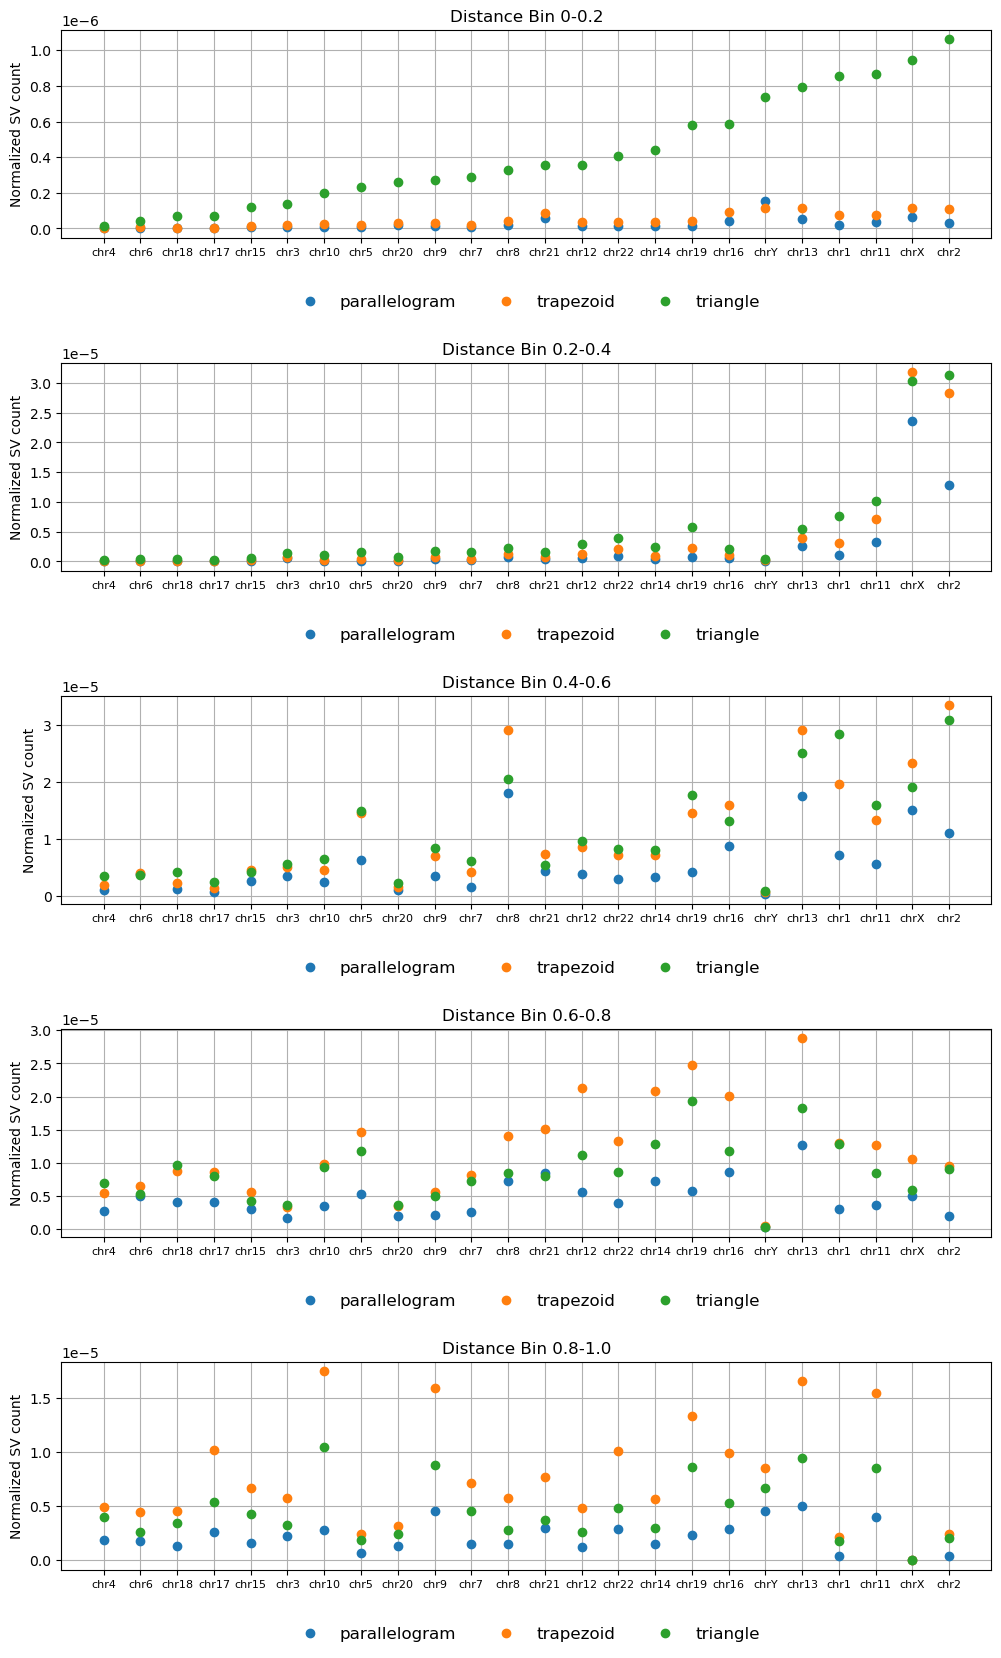

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# Ensure 'chr' is string
sum_count['chr'] = sum_count['chr'].astype(str)

# Get unique shapes and distance bins
shape_cols = sum_count["shape"].unique()
bins_order = sorted(sum_count["dist_bin"].unique(), key=lambda x: float(str(x).split('-')[0]))  # sort bins numerically

# Sort chromosomes by triangle normalized count in the first distance bin
bin0_df = sum_count[
    (sum_count["dist_bin"] == bins_order[0]) &
    (sum_count["shape"] == "triangle")
].copy()
chromosomes = bin0_df.sort_values("normalized_count", ascending=True)["chr"].tolist()

# Figure layout
n_bins = len(bins_order)
cols = 1
rows = (n_bins + cols - 1) // cols
fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(12*cols, 4*rows),
    sharey=False,
    gridspec_kw={"hspace": 0.6}
)
axes = axes.flatten()

# Loop through bins
for i, bin_label in enumerate(bins_order):
    ax = axes[i]

    df_bin = sum_count[sum_count["dist_bin"] == bin_label].copy()
    if df_bin.empty:
        ax.axis('off')
        continue

    for shape in shape_cols:
        subset = df_bin[df_bin["shape"] == shape].copy()
        subset = subset[subset["chr"].isin(chromosomes)]
        subset = subset.set_index("chr").reindex(chromosomes)

        # Plot markers only
        ax.plot(
            subset.index.astype(str),
            subset["normalized_count"],
            marker='o',
            linestyle='None',
            label=shape
        )

    # x-axis labels with "chr\nn="
    xtick_labels = [f"{chr_}" for chr_ in chromosomes]
    ax.set_xticks(range(len(chromosomes)))
    ax.set_xticklabels(xtick_labels, rotation=0, fontsize=8)

    # Horizontal legend under the plot
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.2),
        ncol=len(shape_cols),
        frameon=False,
        fontsize=12
    )
    ax.set_title(f"Distance Bin {bin_label}")
    ax.set_ylabel("Normalized SV count")
    ax.grid(True)

# Hide extra axes if any
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j//cols, j%cols])

plt.tight_layout()
plt.show()



In [ ]:
### Plot the same bar plots, but this time showing # of bases in SVs 

In [58]:
### SV length distributions with expected HOR sizes from the annotations 

# read in CHM13 HOR sizes > 5% 
chm13_stvs = pd.read_csv("/private/groups/patenlab/mira/centrolign/annotations/stvs_gt.05_12092025_chrfix.tsv", sep="\t")

chm13_stvs.head()

,chr,name,min_range,max_range,counts,chrom_freq
0,chr1,S1C1/5/19H1L.1-5(_6/4_5){1}-6,1230,1388,79669.0,0.072574
1,chr1,S1C1/5/19H1L.1-5(_6/4_5){2}-6,1567,1870,111865.0,0.101903
2,chr1,S1C1/5/19H1L.1-5(_6/4_5){3}-6,1939,2211,102308.0,0.093197
3,chr1,S1C1/5/19H1L.1-5(_6/4_5){4}-6,2282,2550,70546.0,0.064264
4,chr1,S1C1/5/19H1L.1-5(_6/4_5){5}-6,2618,2893,65519.0,0.059685


In [22]:
df_sub = df_induced_direct_combined[(df_induced_direct_combined["label"] == "induced") & (df_induced_direct_combined["shape"] == "triangle")].copy()

df_sub.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist,label,shape,distance_bin
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844,induced,triangle,0.8–1.0
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844,induced,triangle,0.8–1.0
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844,induced,triangle,0.8–1.0
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844,induced,triangle,0.8–1.0
8,HG002.1,30654,30995,HG03742.2,19156,19157,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,341,0.917844,induced,triangle,0.8–1.0


/data/tmp/ipykernel_3334986/781658909.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


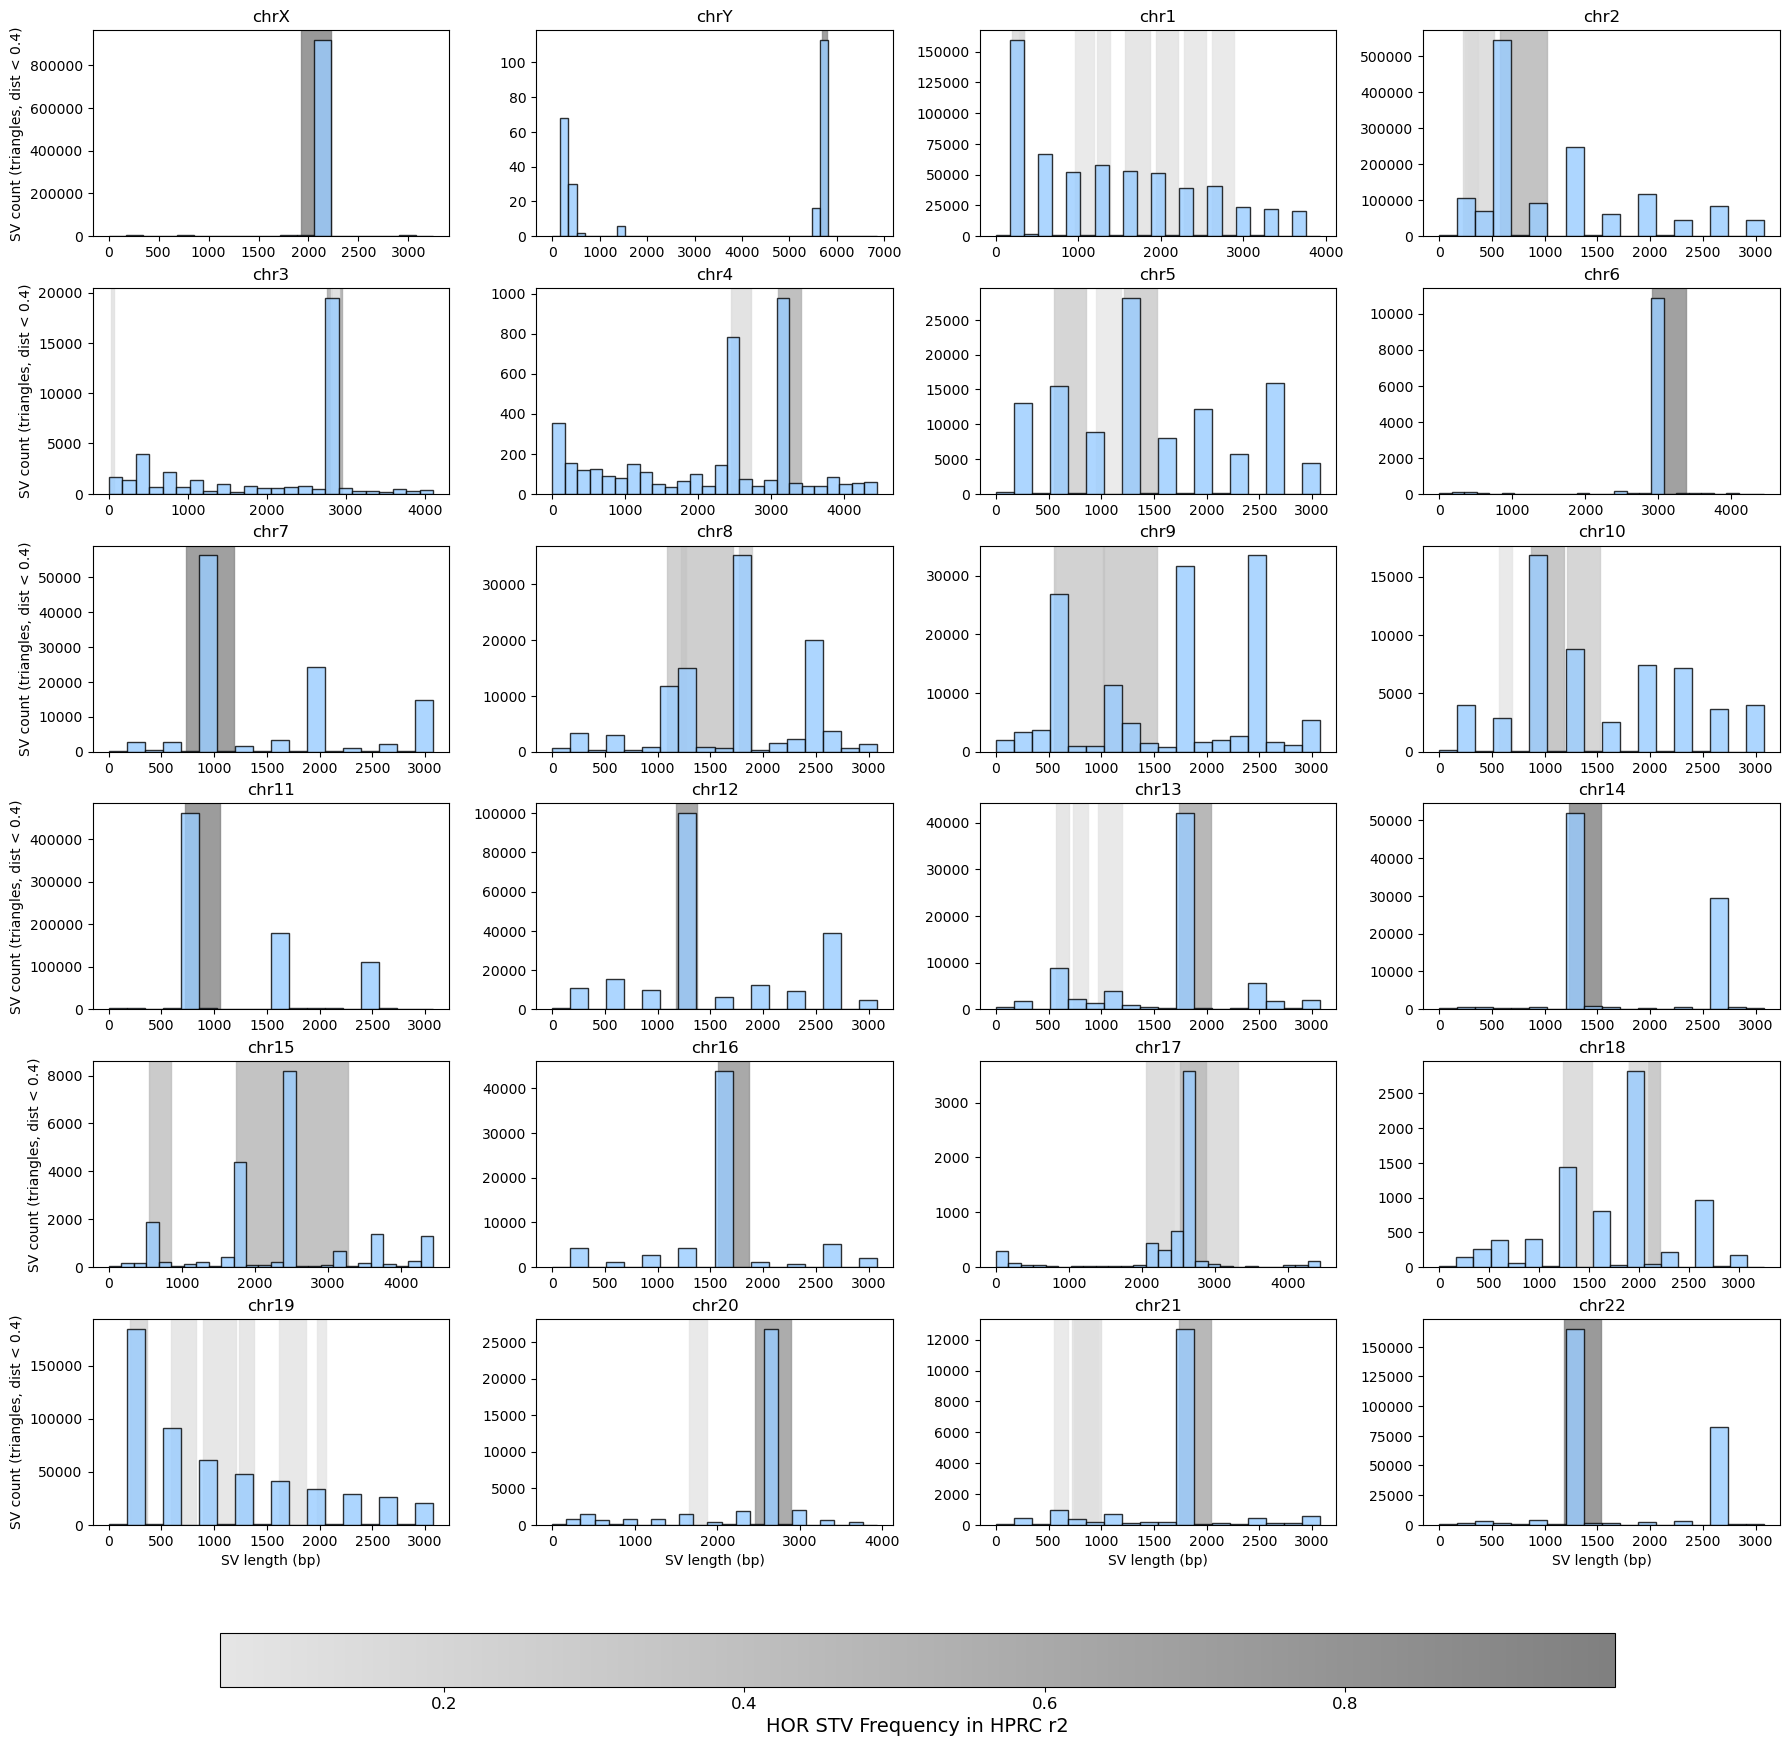

In [ ]:
# Plot SV length distributions for all chromosomes, with expected HOR size overlayed
# Incorporated shading by frequency for HOR sizes 
# Incorporated fixed bins at 171 bp so the monomers pop

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import gridspec


# --------- LIGHTENED GREYS COLORMAP (key fix) ----------
def lighten_greys(low=0.65, high=0.90):
    """
    Create a lightened grayscale colormap where:
        0.0 maps to a light gray,
        1.0 maps to a slightly darker gray.
    The frequency range (Normalize) stays FULL.
    """
    return mcolors.LinearSegmentedColormap.from_list(
        "light_greys_fullrange",
        [cm.Greys(low), cm.Greys(high)]
    )


# ----------------------
# 3. Plot histograms on same grid
# ----------------------
n_chrom = len(chromosomes)
n_cols = 4
n_rows = int(np.ceil(n_chrom / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*3),
                         sharex=False, sharey=False)
axes = axes.flatten()


# --------- NORMALIZATION: FULL RANGE OF TRUE FREQUENCIES ----------
freq_min = chm13_stvs["chrom_freq"].min()
freq_max = chm13_stvs["chrom_freq"].max()
norm = mcolors.Normalize(vmin=freq_min, vmax=freq_max)

# --------- NEW LIGHT GRAY COLORMAP ----------
# Light gray colormap from RGB tuples
cmap = mcolors.LinearSegmentedColormap.from_list(
    "light_greys_rev",
    [(0.9, 0.9, 0.9),  # light gray → low frequency
     (0.5, 0.5, 0.5)]     # darker gray → high frequency
)

for i, chrom in enumerate(chromosomes):
    ax = axes[i]

    lengths = df_sub[df_sub["chr"] == chrom]["length"]

    # Determine max x limit for histogram
    ranges = chm13_stvs[chm13_stvs["chr"] == chrom]
    if not ranges.empty:
        max_len = ranges["max_range"].max()
        x_max = max(max_len + 1000, 3000)
    else:
        x_max = 3000

    # Histogram bins of 171 bp
    x_bins = np.arange(0, x_max + 171, 171)
    ax.hist(lengths, bins=x_bins,
        color=(0.6, 0.8, 1.0),  # RGB tuple for light blue
        edgecolor='black',
        alpha=0.8)

    # Plot rectangles for each STV shaded by chrom_freq
    for _, row in ranges.iterrows():
        color = cmap(norm(row["chrom_freq"]))
        ax.axvspan(
            row["min_range"], row["max_range"],
            color=color, alpha=0.8, edgecolor=None, zorder=0
        )

    ax.set_title(chrom)

    # y-axis label only on left
    if i % n_cols == 0:
        ax.set_ylabel("SV count (triangles, dist < 0.4)")
    else:
        ax.set_ylabel("")

    # x-axis labels only on bottom row
    if i // n_cols == n_rows - 1:
        ax.set_xlabel("SV length (bp)")
    else:
        ax.set_xlabel("")


# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Final layout
# Add colorbar in its own axes below the plots
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a separate axes for colorbar: [left, bottom, width, height]
cbar_ax = fig.add_axes([0.125, 0.06, 0.775, 0.03])  # tweak bottom/height as needed
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('HOR STV Frequency in HPRC r2',fontsize=14)
cbar.ax.tick_params(labelsize=12)


plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()


In [ ]:
### For every sample pair, calculate the # of SVs / mean length of the two arrays 